# Polynomial Mutation Bounded

Dado um indivíduo $x = (x_1, x_2, \ldots, x_n)\in\prod_{i=1}^n[l_i,s_i]\subset\mathbb{R}^n$, a mutação polinomial é aplicada em cada coordenada $i$ com probabilidade $p_m$. Quando a mutação é aplicada, o valor $x_i$ é atualizado de acordo com:

$$
\delta_1 = \frac{x_i - l_i}{s_i - l_i}, \quad \delta_2 = \frac{s_i - x_i}{s_i - l_i}, \quad u \sim U(0, 1).
$$

$$
\quad \Delta = 
\begin{cases}
\left( 2u + (1 - 2u)(1 - \delta_1)^{\eta + 1} \right)^{\frac{1}{\eta + 1}} - 1 & \text{se }u < 0.5,\\[1.2em]
1 - \left( 2(1 - u) + 2(u - 0.5)(1 - \delta_2)^{\eta + 1} \right)^{\frac{1}{\eta + 1}} & \text{se }u\ge0.5.
\end{cases}
$$

O novo valor de $x_i$ após a mutação é dado por:

$$
x_i' = x_i + \Delta (s_i - l_i).
$$

Como o cada coordenada $x_i'$ é limitada ao intervalo $[l_i, s_i]$, calculamos o seguinte resultado final:

$$
x_i' = \min(\max(x_i', l_i), s_i).
$$


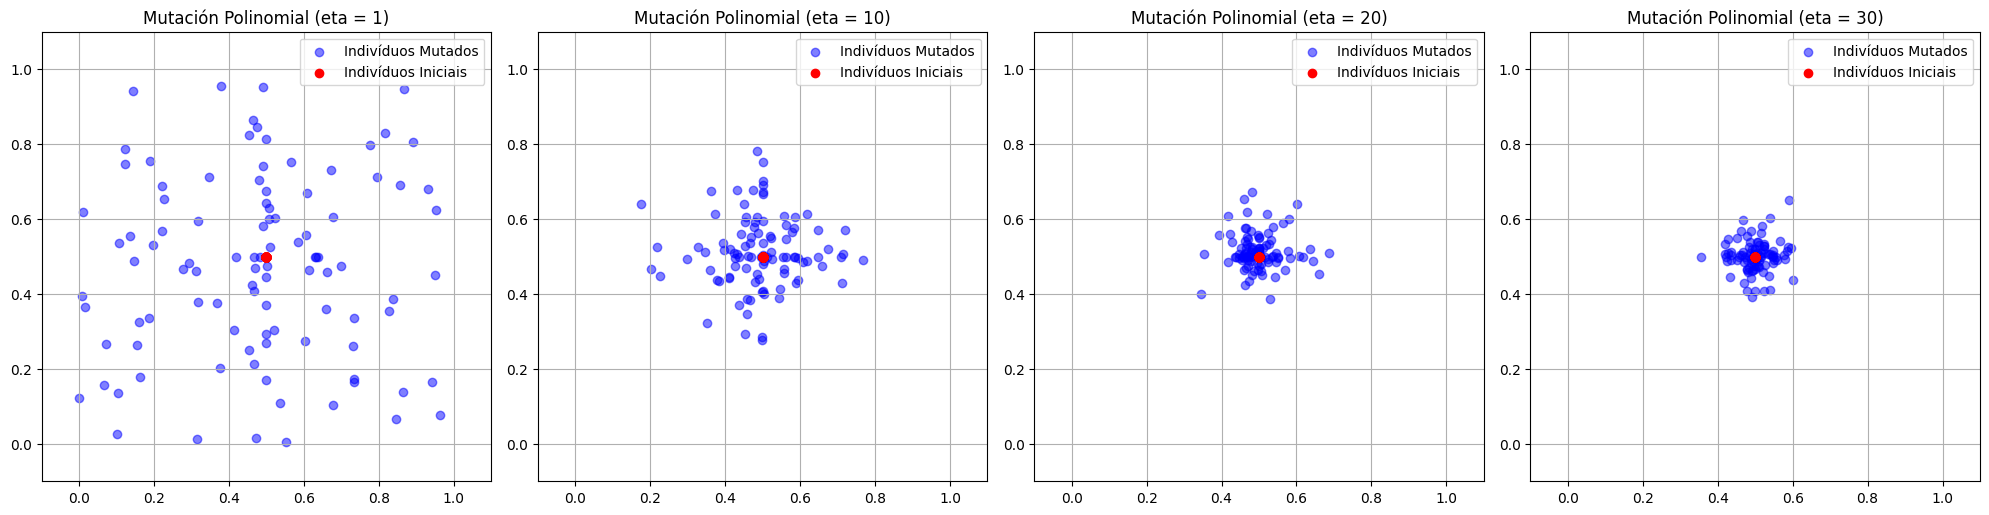

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

def polynomial_mutation(
    individual: np.ndarray, 
    bounds: list[tuple[float, float]],
    eta: float = 25.0,
    mutation_rate: float = 0.1,
    per_gene_prob: float | None = None
    ) -> np.ndarray:
    """
    Polynomial mutation (Deb, 2001). Aplica por gene com prob ~ 1/n.
    Mantém a mesma probabilidade global de mutação do código original (_MUTATION_RATE).
    """
    n = individual.shape[0]
    if per_gene_prob is None:
        per_gene_prob = 1 / n
    if random.random() < mutation_rate:
        y = individual.copy()
        for i in range(n):
            if random.random() < per_gene_prob:
                yl, yu = bounds[i]
                if yu <= yl:  # proteção
                    continue
                y_i = y[i]
                # Normalizar para [0,1] dentro dos limites
                delta1 = (y_i - yl) / (yu - yl)
                delta2 = (yu - y_i) / (yu - yl)
                r = random.random()

                mut_pow = 1.0 / (eta + 1.0)
                if r < 0.5:
                    xy = 1.0 - delta1
                    val = 2.0 * r + (1.0 - 2.0 * r) * (xy ** (eta + 1.0))
                    deltaq = (val ** mut_pow) - 1.0
                else:
                    xy = 1.0 - delta2
                    val = 2.0 * (1.0 - r) + 2.0 * (r - 0.5) * (xy ** (eta + 1.0))
                    deltaq = 1.0 - (val ** mut_pow)

                y[i] = y_i + deltaq * (yu - yl)
                # Garantir limites
                y[i] = np.clip(y[i], yl, yu)
        return y

    return individual

# Parâmetros para demonstração
bounds = [(0,1),(0,1)]

indpb = 0.9  # Probabilidade de mutação

# Gerar indivíduos aleatórios dentro dos limites definidos
population_size = 100
individuals = [
    [0.5, 0.5] for _ in range(population_size)
]

# Diferentes valores de eta para testar
etas = [1, 10, 20, 30]

# Visualização gráfica
fig, axes = plt.subplots(1, len(etas), figsize=(20, 5))

# Aplicar mutação polinomial para cada valor de eta e plotar
for i, eta in enumerate(etas):
    mutated_individuals = [
        polynomial_mutation(np.array(individual.copy()), bounds, eta, 1, indpb) for individual in individuals
    ]

    # Separar coordenadas dos indivíduos mutados para plotagem
    mutated_x = [individual[0] for individual in mutated_individuals]
    mutated_y = [individual[1] for individual in mutated_individuals]

    # Plotando os resultados
    axes[i].scatter(mutated_x, mutated_y, color='blue', alpha=0.5, label='Indivíduos Mutados')
    axes[i].scatter([individual[0] for individual in individuals], [individual[1] for individual in individuals], color='red', label='Indivíduos Iniciais')
    axes[i].set_xlim(-0.1, 1.1)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].set_aspect('equal')
    axes[i].set_title(f'Mutación Polinomial (eta = {eta})')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

A **polynomial mutation** é um dos operadores de mutação mais usados em algoritmos evolutivos de codificação real (como NSGA-II/III). Ela foi proposta por Deb e Agrawal (1995) e tem uma formulação probabilística controlada pelo parâmetro de distribuição $\eta$, chamado de **mutation distribution index**.

Outra forma de definir essa mesma operação é dada a seguir.

## Definição

Seja um indivíduo $x = (x_1, x_2, \ldots, x_n) \in \mathbb{R}^n$, definido dentro de limites inferiores e superiores $l_i \leq x_i \leq s_i$.
A mutação polinomial altera cada componente $x_i$ com probabilidade $p_m$, resultando em $x_i'$.

Para cada variável $x_i$:

1. Sorteia-se $u \sim U(0,1)$.
2. Define-se:

$$
\delta_i =
\begin{cases}
(2u)^{\tfrac{1}{\eta+1}} - 1, & \text{se } u < 0.5, \\[1.2em]
1 - \big(2(1-u)\big)^{\tfrac{1}{\eta+1}}, & \text{se } u \geq 0.5.
\end{cases}
$$

3. O novo valor da variável é:

$$
x_i' = x_i + (s_i - l_i) \cdot \delta_i.
$$

4. Por fim, aplica-se o **clamping** aos limites:

$$
x_i' = \min\big(s_i, \max(l_i, x_i')\big).
$$

Desta forma podemos verificar o efeito da variação do $\eta$ observando o valor de $\delta(u)$ no intervalo $[0,1]$. 

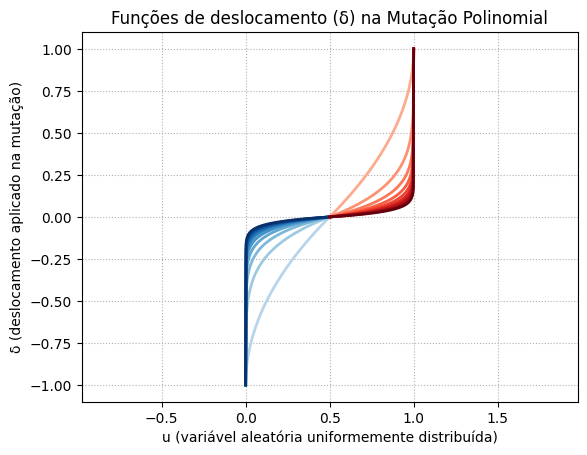

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Famílias de funções para a mutação polinomial:
# - quando u < 0.5 (delta para a "cauda esquerda")
# - quando u >= 0.5 (delta para a "cauda direita")
delta_left_family = [
    lambda u, eta=eta: (2*u)**(1/(eta+1)) - 1
    for eta in np.linspace(1, 30, 10)
]

delta_right_family = [
    lambda u, eta=eta: 1 - (2*(1-u))**(1/(eta+1))
    for eta in np.linspace(1, 30, 10)
]

# Domínios para u
u_left = np.linspace(0, 0.5, 200)   # região u < 0.5
u_right = np.linspace(0.5, 1, 200)  # região u >= 0.5

# Colormaps
colors_left = plt.colormaps.get("Blues")(np.linspace(0.3, 1, len(delta_left_family)))
colors_right = plt.colormaps.get("Reds")(np.linspace(0.3, 1, len(delta_right_family)))

# Plot funções para u < 0.5
for f, c in zip(delta_left_family, colors_left):
    delta = f(u_left)
    plt.plot(u_left, delta, color=c, linewidth=2)

# Plot funções para u >= 0.5
for f, c in zip(delta_right_family, colors_right):
    delta = f(u_right)
    plt.plot(u_right, delta, color=c, linewidth=2)

plt.xlabel("u (variável aleatória uniformemente distribuída)")
plt.ylabel("δ (deslocamento aplicado na mutação)")
plt.title("Funções de deslocamento (δ) na Mutação Polinomial")
plt.grid(True, linestyle=":")
plt.axis("equal")
plt.show()


## Intuição

* O parâmetro $\eta > 0$ controla a “distribuição” dos passos da mutação:

  * **Baixo $\eta$** → mutações mais largas (exploração).
  * **Alto $\eta$** → mutações mais pequenas e locais (exploração refinada).

* A função que define $\delta_i$ é chamada de “polinomial” porque a probabilidade acumulada de $\delta_i$ segue uma distribuição polinomial com grau $\eta$.

## Quadro Comparativo

| **Etapa**                                 | **Forma simplificada**                                      | **Forma completa (Deb)**                                                                                  | **Comentário**                                                                                                          |
| ----------------------------------------- | ----------------------------------------------------------- | --------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| **1. Definição do deslocamento relativo** | $\delta \in [-1,1]$, obtido por inversão da CDF polinomial. | Introduz-se: <br> $\delta_1 = \frac{x_i - l_i}{u_i - l_i}, \quad \delta_2 = \frac{u_i - x_i}{u_i - l_i}$. | Enquanto a forma simples assume deslocamento livre, Deb normaliza as distâncias até as bordas inferior/superior.        |
| **2. Geração do número aleatório**        | $u \sim U(0,1)$.                                            | Mesmo procedimento.                                                                                       | O sorteio uniforme é a base para a inversão da CDF.                                                                     |
| **3. Caso $u < 0.5$**                     | $\delta = (2u)^{\tfrac{1}{\eta+1}} - 1.$                    | $\Delta = \big(2u + (1-2u)(1-\delta_1)^{\eta+1}\big)^{\tfrac{1}{\eta+1}} - 1.$                            | Aqui o deslocamento é para **baixo**. A diferença é que a CDF é “cortada” em função da distância disponível $\delta_1$. |
| **4. Caso $u \geq 0.5$**                  | $\delta = 1 - \big(2(1-u)\big)^{\tfrac{1}{\eta+1}}.$        | $\Delta = 1 - \big(2(1-u) + 2(u-0.5)(1-\delta_2)^{\eta+1}\big)^{\tfrac{1}{\eta+1}}.$                      | Aqui o deslocamento é para **cima**, condicionado pela distância $\delta_2$.                                            |
| **5. Atualização da variável**            | $x_i' = x_i + \delta \,(u_i-l_i).$                          | $x_i' = x_i + \Delta \,(u_i-l_i).$                                                                        | Na completa, o $\Delta$ já respeita as distâncias até as bordas.                                                        |
| **6. Garantia de limites**                | Correção via *clamping*: $\min(\max(x_i',l_i),u_i).$        | Idem.                                                                                                     | Ambas as versões aplicam o corte final, mas na forma completa a probabilidade de precisar clamp é bem menor.            |